In [125]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

%matplotlib inline

In [126]:
N_PTS = 50

In [127]:
def tangle(points, weights=0.01, steps=1, normalize=True):
    for s in range(steps):
        diff = np.diff(points, axis=0)
        current_length = np.linalg.norm(diff, axis=-1)
        #target_length = np.mean(current_length) * 1.01
        #length_error = current_length - target_length
        curve = np.diff(diff, axis=0) * 0.1
        curve_right = curve - (np.sum(curve * diff[1:], axis=-1) / current_length[1:])[:, None] * diff[1:]
        curve_left = curve - (np.sum(curve * diff[:-1], axis=-1) / current_length[:-1])[:, None] * diff[:-1]
        sqr_dist = np.sum(diff * diff, axis=-1, keepdims=True)
        diff2 = points[2:] - points[:-2]
        sqr_dist2 = np.sum(diff2 * diff2, axis=-1, keepdims=True)
        if normalize:
            sqr_dist /= np.mean(sqr_dist)
            sqr_dist2 /= np.mean(sqr_dist2)
        diff2 /= sqr_dist2

        # Adjust length
        force = np.zeros_like(points)
        #length_force = length_error[:, None] * diff / current_length[:, None]
        force[:len(diff)] = diff #-length_force
        force[1:] -= diff #length_force
        
        force[:len(curve)] -= curve_left
        force[2:] -= curve_right
        
        points = points + weights * force
    return points

In [128]:
def generate():
    points = np.random.uniform(-1, 1, (N_PTS, 2))
    points = np.concatenate((np.linspace(-1, 1, N_PTS)[..., None], points), axis=-1)
    points[0] = np.array([-1, 0, 0])
    points[-1] = np.array([1, 0, 0])
    points[1] = np.array([-0.98, 0, 0])
    points[-2] = np.array([0.98, 0, 0])
    points[:, 2] *= 0.75
    points[:, 2] += 1
    
    weights = np.full((N_PTS, 1), 0.2)
    weights[0] = 0
    weights[-1] = 0
    tangled_pts = tangle(points, weights, steps=80)
    return tangled_pts

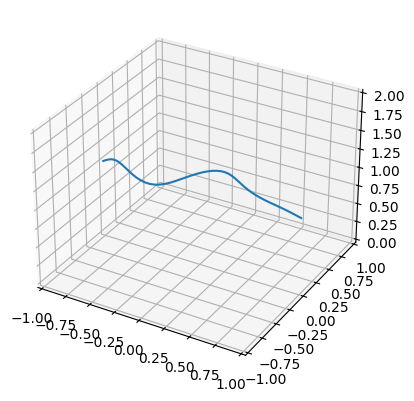

In [129]:
tangled_pts = generate()
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 2)
# ax.scatter(*tangled_pts.T)
ax.plot(*tangled_pts.T)

In [130]:
def skew(vecs):
    zeros = np.zeros(vecs.shape[:-1])
    arr = np.array([[        zeros, -vecs[..., 2],  vecs[..., 1]],
                    [ vecs[..., 2],         zeros, -vecs[..., 0]],
                    [-vecs[..., 1],  vecs[..., 0],         zeros]])
    # (3, 3, *batch)
    return np.moveaxis(arr, (0, 1), (-2, -1))

In [131]:
WIDTH = 640
HEIGHT = 480

import config
# CAMERA_POS = np.array([[0,   0,   0],
#                        [0.5, 0,   0],
#                        [0,   0.5, 0]])
# CAMERA_ROT = np.repeat(np.eye(3)[None], 3, 0)
# CAMERA_ROT[1] = np.array([[1, 0, 0],
#                           [0, 1 / np.sqrt(2), 1 / -np.sqrt(2)],
#                           [0, 1 / np.sqrt(2), 1 / np.sqrt(2)]])

# CAMERA_POS = config.G[..., :3, 3]
# CAMERA_ROT = config.G[..., :3, :3]

# CAMERA_POS_1 = np.random.uniform([-0.25, -0.25, -0.15], [0.25, 0.25, 0.1], size=3)
CAMERA_POS_1 = np.array([0.5, 0, 0])
CAMERA_ROT_1 = np.random.uniform([-12, -12, -12], [12, 12, 12], size=3)
CAMERA_ROT_1 = Rotation.from_euler('xyz', CAMERA_ROT_1, degrees=True).as_matrix()
G_1 = np.zeros((4, 4))
G_1[:3, :3] = CAMERA_ROT_1
G_1[:3, 3] = CAMERA_POS_1
G_1[3, 3] = 1

CAMERA_POS_2 = np.array([0, 0.5, 0])
CAMERA_POS_2 = np.random.uniform([-0.25, -0.25, -0.15], [0.25, 0.25, 0.1], size=3)
CAMERA_ROT_2 = np.random.uniform([-12, -12, -12], [12, 12, 12], size=3)
CAMERA_ROT_2 = Rotation.from_euler('xyz', CAMERA_ROT_2, degrees=True).as_matrix()
G_2 = np.zeros((4, 4))
G_2[:3, :3] = CAMERA_ROT_2
G_2[:3, 3] = CAMERA_POS_2
G_2[3, 3] = 1


R_1 = G_1[:3, :3].T
T_1 = -R_1 @ G_1[:3, 3]
ESSENTIALS_1 = skew(T_1) @ R_1
PROJECTION_1 = np.linalg.inv(G_1)[:3]
assert PROJECTION_1.shape == (3, 4)

R_2 = G_2[:3, :3].T
T_2 = -R_2 @ G_2[:3, 3]
ESSENTIALS_2 = skew(T_2) @ R_2
PROJECTION_2 = np.linalg.inv(G_2)[:3]
assert PROJECTION_2.shape == (3, 4)


def project(points, p_matrix):
    print(p_matrix.shape, points.shape)
    local_pts = p_matrix @ points[..., None]
    return local_pts[..., 0] / local_pts[..., 2:, 0], local_pts[..., 2, 0]

# def draw(points):
#     canvas = np.ones((HEIGHT, WIDTH))
#     points = points.astype(int)
#     for i in range(len(points) - 1):
#         rr, cc = skimage.draw.line(points[i][1], points[i][0], points[i+1][1], points[i+1][0])
#         canvas[rr, cc] = 0
#     dist = sp.ndimage.distance_transform_edt(canvas)
#     grad_x = np.diff(dist, axis=1)
#     grad_y = np.diff(dist, axis=0)
#     return points, canvas, dist, grad_x, grad_y

# def optimize(points, grad_x, grad_y, weights=1, steps=100):
#     for s in range(steps):
#         force = np.zeros_like(points)

#         for c in range(3):
#             grads_x = sample_bilinear(grad_x[c], points)
#             grads_y = sample_bilinear(grad_y[c], points)
#             grads = np.stack((grads_x, grads_y), axis=-1)
#             force -= weights * grads

#             diff = np.diff(points, axis=0)
#             sqr_mag = np.sum(diff * diff, axis=-1, keepdims=True)
#             diff = diff / sqr_mag
            
#             force[:len(diff)] += diff
#             force[1:] -= diff

#         points = points + force

#         points += np.random.normal(0, 10 / (s + 1), points.shape)
#         points = np.clip(points, np.zeros(2), np.array((WIDTH, HEIGHT)))
#     return points

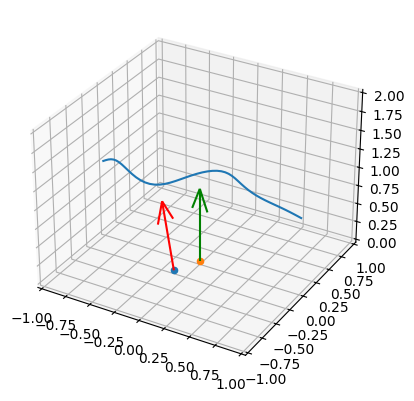

In [132]:
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 2)
# ax.scatter(*tangled_pts.T)
ax.plot(*tangled_pts.T)
ax.scatter(*CAMERA_POS.T)
ax.scatter(0, 0, 0)
ax.quiver(*CAMERA_POS.T, *CAMERA_ROT[..., 2].T, length=1, normalize=True, zorder=1, color='red')
ax.quiver(0, 0, 0, 0, 0, 1, length=1, normalize=True, zorder=1, color='green')

In [133]:
def intersect_curves(epipolar_lines, points_h_2d):
    offsets = np.einsum('ik,jk->ij', epipolar_lines, points_h_2d) #np.sum(epipolar_lines[:, :, None] * points_h_2d[:, None], axis=-1) # (c, n1, 1, 3) * (c, 1, n2, 3)
    sgn = np.sign(offsets)
    flip = sgn[..., 1:] - sgn[..., :-1]
    n1, n2 = np.nonzero(flip)
    # Todo: handle multiple cameras (different number of intersects)
    diff = points_h_2d[n2] - points_h_2d[n2 + 1]
    rate = np.sum(epipolar_lines[n1] * diff, axis=-1)
    factor = (-offsets[n1, n2] / rate)[..., None]
    rate_normalized = rate / (np.linalg.norm(epipolar_lines[n1], axis=-1) * np.linalg.norm(diff, axis=-1))
    return points_h_2d[n2] + factor * diff, rate_normalized, n1

# def pick_candidates(intersections):
    # pick candidates based on proximity and curvature to previous points

    # pass

MovieWriter ffmpeg unavailable; using Pillow instead.


(3, 4) (50, 4)
(3, 4) (50, 4)
(3, 4) (50, 4)


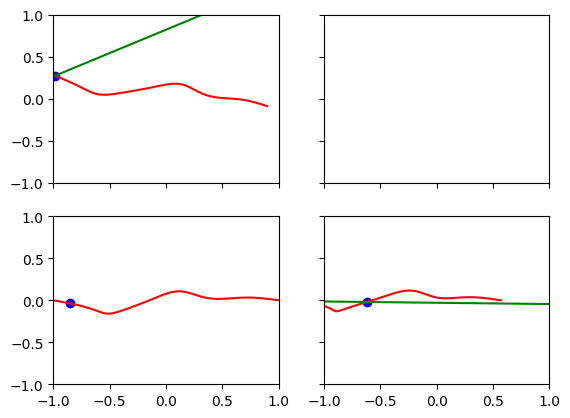

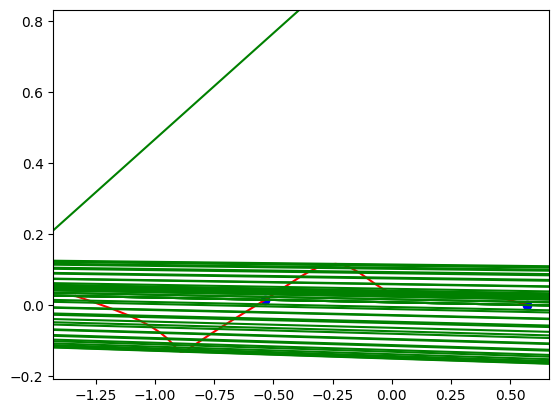

In [140]:
tangled_pts_h = np.concatenate((tangled_pts, np.ones((50, 1))), axis=-1)
P = np.zeros((3, 4))
P[:3, :3] = np.eye(3)
points_2d_h, depth = project(tangled_pts_h, P)

last_depths = []
last_point = None
all_depths = []

points_2d_b, depth = project(tangled_pts_h, PROJECTION_1)
points_2d_c, depth = project(tangled_pts_h, PROJECTION_2)

epipolar_lines_1 = (ESSENTIALS_1 @ points_2d_h[..., None])[..., 0]
intersections_1, rate_normalized, n1 = intersect_curves(epipolar_lines_1, points_2d_b)
epipolar_lines_2 = (ESSENTIALS_2 @ points_2d_h[..., None])[..., 0]
intersections_2, rate_normalized, n2 = intersect_curves(epipolar_lines_2, points_2d_c)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 0].set_xlim((-1, 1))
axs[0, 0].set_ylim((-1, 1))

TEST_PT = 2

axs[1, 0].plot(*points_2d_h[..., :2].T, color='red')
axs[1, 1].plot(*points_2d_b[..., :2].T, color='red')
axs[0, 0].plot(*points_2d_c[..., :2].T, color='red')
axs[1, 0].scatter(*points_2d_h[TEST_PT, :2], color='blue')
axs[1, 1].scatter(*intersections_1[n1==TEST_PT][..., :2].T, color='blue')
axs[0, 0].scatter(*intersections_2[n2==TEST_PT][..., :2].T, color='blue')

def points_on_epipolar(epipolar):
    a, b, c = epipolar
    p1 = np.array([a, b])
    p1 = -p1 * c / np.sum(p1 * p1)
    p2 = p1 + np.array([b, -a])
    return p1, p2

p1, p2 = points_on_epipolar(epipolar_lines_1[TEST_PT])
axs[1, 1].axline(p1, p2, color='green')

p1, p2 = points_on_epipolar(epipolar_lines_2[TEST_PT])
axs[0, 0].axline(p1, p2, color='green')
fig = plt.figure() 

# marking the x-axis and y-axis 
axis = plt.axes()
  
# initializing a line variable
line, = axis.plot(*points_2d_b[..., :2].T, color='red')
scatter = axis.scatter(*intersections_1[..., :2].T, color='blue')
p1, p2 = points_on_epipolar(epipolar_lines_2[0])
axl = axis.axline(p1, p2, color='green')

def animate(i):
    scatter.set_offsets(intersections_1[n1==int(i)][..., :2])
    p1, p2 = points_on_epipolar(epipolar_lines_1[int(i)])
    axl = axis.axline(p1, p2, color='green')
    return [scatter, axl]

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate,
                     frames = N_PTS, interval = 200, blit = True) 
anim.save('intersections.gif')

In [135]:
def get_depths(points1_matched, intersections, transformation):
    # get ray directions of matching points
    global_pts2 = (transformation[..., :3] @ intersections[..., None])[..., 0]
    print(global_pts2.shape)
    # get other camera origin (same as ray origin of matching points)
    translation = transformation[None, ..., 3]
    # find perpendicular displacement from origin to each ray
    # by subtracting projection of translation onto ray
    projection = (np.sum(translation * global_pts2, axis=-1, keepdims=True)
                                   / np.sum(global_pts2 * global_pts2, axis=-1, keepdims=True)) * global_pts2
    perpendicular = translation - projection
    print(projection, perpendicular)
    # find depths as length of perpendiculars divided by component of first camera rays on perpendiculars
    # basically, rays cast from camera 1 origin should reach the ray cast from camera 2
    return np.sum(perpendicular * perpendicular, axis=-1) / np.sum(points1_matched * perpendicular, axis=-1)

In [136]:
TRANSFORMATION_1 = np.concatenate((CAMERA_ROT_1, CAMERA_POS_1[..., None]), axis=-1)
depths_1 = get_depths(points_2d_h[n1], intersections_1, TRANSFORMATION_1)
d_list_1 = [[] for _ in range(N_PTS)]
for j, idx in enumerate(n1):
    if depths_1[j] > 0:
        d_list_1[idx].append(depths_1[j])

TRANSFORMATION_2 = np.concatenate((CAMERA_ROT_2, CAMERA_POS_2[..., None]), axis=-1)
depths_2 = get_depths(points_2d_h[n2], intersections_2, TRANSFORMATION_2)
d_list_2 = [[] for _ in range(N_PTS)]
for j, idx in enumerate(n2):
    if depths_2[j] > 0:
        d_list_2[idx].append(depths_2[j])

err = [np.array(c1)[:, None] - np.array(c2)[None, :] for c1, c2 in zip(d_list_1, d_list_2)]
assert len(err) == len(points_2d_h)
assert len(err) == N_PTS

(132, 3)
[[ 1.35025522e-01  3.97286814e-19 -2.21992949e-01]
 [ 1.00000000e-01  3.36956542e-19  2.00000000e-01]
 [ 3.31673840e-01  4.54221066e-03 -2.36238761e-01]
 [ 3.31673840e-01  4.54221066e-03 -2.36238761e-01]
 [ 1.49673232e-01  4.40194471e-03 -2.28943579e-01]
 [ 3.17195895e-01  8.98980585e-03 -2.40632282e-01]
 [ 1.63432989e-01  8.75586781e-03 -2.34370407e-01]
 [ 3.03326371e-01  1.33756399e-02 -2.43879869e-01]
 [ 1.76435256e-01  1.30845774e-02 -2.38572887e-01]
 [ 2.90587794e-01  1.77108034e-02 -2.46046659e-01]
 [ 1.88662178e-01  1.74003084e-02 -2.41733119e-01]
 [ 2.79378319e-01  2.19710523e-02 -2.47293727e-01]
 [ 2.00104223e-01  2.16792231e-02 -2.44009063e-01]
 [ 2.69943934e-01  2.60898805e-02 -2.47833730e-01]
 [ 2.10618579e-01  2.58465226e-02 -2.45522017e-01]
 [ 2.62360232e-01  2.99560153e-02 -2.47890826e-01]
 [ 2.19913519e-01  2.97747085e-02 -2.46390484e-01]
 [ 2.56520774e-01  3.34140888e-02 -2.47671109e-01]
 [ 2.27891270e-01  3.32944984e-02 -2.46784684e-01]
 [ 2.52131393e-01  3.6

In [137]:
# TODO: pick multiple possible accepted depths and do beam search
# DEPTH_THRESHOLD = 0.02
# todo: use variable threshold based on rate
# accept = [er < DEPTH_THRESHOLD for er in err]
accept = [np.argmin(np.abs(er)) if er.size > 0 else -1 for er in err]
print(accept)
idx = [np.unravel_index(acc, er.shape) if acc >= 0 else -1 for acc, er in zip(accept, err)]
print(idx, len(idx))
depths = np.array([0.5 * (d_list_1[i][idx[i][0]] + d_list_2[i][idx[i][1]]) if idx[i] != -1 else -1 for i in range(N_PTS)])
print(depths)
print(d_list_1)
points_3d = points_2d_h * depths[..., None]

[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 1, -1]
[-1, (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), -1, (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (2, 0), (2, 0), (2, 0), (2, 0), (2, 0), (1, 0), (3, 0), (3, 0), (3, 0), (1, 0), (1, 0), -1] 50
[-1.          1.03945075  1.07625954  1.107922    1.13223161  1.14747185
  1.15262656  1.14756947  1.13317729  1.11131658  1.08468177  1.05649573
  1.03011369  1.00859269  0.99429989  0.98862986  0.99188362  1.00332917
  1.02142138  1.0441225   1.06925027  1.09478726  1.11910418  1.14107344
  1.16007273  1.17589804  1.18861958  1.1984199  -1.          1.2097441
  1.21117339  1.20949924  1.20445462  1.19586644  1.18377612  1.16852717
  1.15079169  1.1

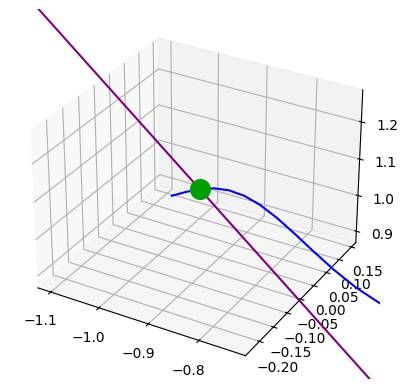

In [138]:
ax = plt.figure().add_subplot(projection='3d')
# ax.scatter(*tangled_pts.T)

candidates_3d_1 = points_2d_h[TEST_PT, :, None] * np.array(d_list_1[TEST_PT])[None]
candidates_3d_2 = points_2d_h[TEST_PT, :, None] * np.array(d_list_2[TEST_PT])[None]
ax.set_xlim3d(min(np.min(candidates_3d_1[0]), np.min(candidates_3d_2[0])) - 0.2, max(np.max(candidates_3d_1[0]), np.max(candidates_3d_2[0])) + 0.2)
ax.set_ylim3d(min(np.min(candidates_3d_1[1]), np.min(candidates_3d_2[1])) - 0.2, max(np.max(candidates_3d_1[1]), np.max(candidates_3d_2[1])) + 0.2)
ax.set_zlim3d(min(np.min(candidates_3d_1[2]), np.min(candidates_3d_2[2])) - 0.2, max(np.max(candidates_3d_1[2]), np.max(candidates_3d_2[2])) + 0.2)

ax.plot(*tangled_pts.T, color='blue')
ax.scatter(*points_3d[TEST_PT], color='red')
# plt.savefig('reconstruction.png')
ax.scatter(*candidates_3d_1, color='#ff0000', s=50)
ax.scatter(*candidates_3d_2, color='#00a000', s=200)
ax.plot(*np.stack((-10 * points_3d[TEST_PT], 10 * points_3d[TEST_PT]), axis=1), color='purple')

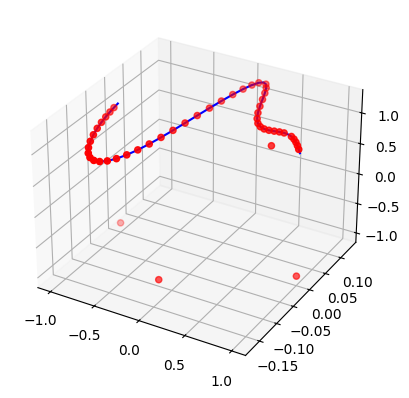

In [139]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*tangled_pts.T, color='blue')
ax.scatter(*points_3d.T, color='red')